## Model Training

#### Import Data and Required Packages

In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [3]:
## laoding the dataset into dataframe
student_data = pd.read_csv(r'C:\Users\Kimo Store\Desktop\project\mlproject\nootbook\data\stud.csv' ,sep="\t")
student_data.head(3)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93


#### Spliting The Data Into Independent And Dependent

In [11]:
X = student_data.drop('math_score' , axis = 1)
X.head(3)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93


In [18]:
## Checking for the type of data
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race_ethnicity               1000 non-null   object
 2   parental_level_of_education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test_preparation_course      1000 non-null   object
 5   math_score                   1000 non-null   int64 
 6   reading_score                1000 non-null   int64 
 7   writing_score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [12]:
y = student_data['math_score']

## Features Selection

In [10]:
## Numerical Data 
numerical_data = student_data.select_dtypes(exclude = "O").columns
numerical_data

Index(['math_score', 'reading_score', 'writing_score'], dtype='object')

In [13]:
## Numerical Data 
categorical_data = student_data.select_dtypes(include = "O").columns
categorical_data

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course'],
      dtype='object')

#### Select Numerical Features Using Correlation

In [25]:
student_data[numerical_data].corr()['math_score']

math_score       1.000000
reading_score    0.817580
writing_score    0.802642
Name: math_score, dtype: float64

#### Conclusion 
* reading_score  and writing_score they have imapct on target column

#### Features Selection Categorical Features

In [26]:
from scipy.stats import f_oneway

In [27]:
result =[]
for col in categorical_data:
    grouped_data = [student_data['math_score'] [student_data[col]==label] for label in student_data[col].unique()]

    f_statistic , p_value = f_oneway(*grouped_data)

    print(f"F_statistic{f_statistic}")
    print(f' P_Value {p_value}')

    alpha = 0.05
    if p_value < alpha :
        result.append(col)

        print("Reject null hypothesis: There is a significant difference between group means")

    else :
        int("Fail to reject null hypothesis: There is no significant difference between group means.")

F_statistic28.979336095030888
 P_Value 9.120185549332254e-08
Reject null hypothesis: There is a significant difference between group means
F_statistic14.593885166332637
 P_Value 1.3732194030370688e-11
Reject null hypothesis: There is a significant difference between group means
F_statistic6.521582600453217
 P_Value 5.592272384107223e-06
Reject null hypothesis: There is a significant difference between group means
F_statistic140.11884154835118
 P_Value 2.4131955993147374e-30
Reject null hypothesis: There is a significant difference between group means
F_statistic32.54264846908886
 P_Value 1.5359134607155386e-08
Reject null hypothesis: There is a significant difference between group means


In [28]:
result

['gender',
 'race_ethnicity',
 'parental_level_of_education',
 'lunch',
 'test_preparation_course']

In [29]:
set(student_data[categorical_data]) - set(result)

set()

#### Conclusion
* We Fall To Drop Any Features All Features Have Significent Impact 

#### Transformation

In [34]:
categorical_data = X.select_dtypes(include = "O").columns
numerical_data = X.select_dtypes(exclude = "O").columns

In [35]:
## transform numerical features and categorical features 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
cat_transformer = OneHotEncoder()

preocessor = ColumnTransformer( 
    [
        ('OneHotEncoder' , cat_transformer , categorical_data) , 
        ('StandardScaler' , numeric_transformer , numerical_data)
    ]
)

In [36]:
## Applying Transformation 
X = preocessor.fit_transform(X)
X.shape

(1000, 19)

#### Spliting The Dataset Into Train And Test 

In [37]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state = 42)
X_train.shape , X_test.shape

((800, 19), (200, 19))

#### Create An Evaluate Func To All Metrics 

In [38]:
def evluate(true , predicted):
    mae = mean_absolute_error(true , predicted)
    mse = mean_absolute_error(true , predicted)
    rmes = np.sqrt(mean_absolute_error(true , predicted))
    score = r2_score(true , predicted)
    return mae , mse , rmes , score


In [40]:
models = {
    'LinearRegression' : LinearRegression() , 
    'Lasso' :Lasso() , 
    'Ridge': Ridge(),
    'KNeighborsRegressor':KNeighborsRegressor() , 
    'DecisionTreeRegressor' : DecisionTreeRegressor(),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGBRegressor':XGBRegressor() , 
    'CatBoostRegressor': CatBoostRegressor(),
    'AdaBoostRegressor':AdaBoostRegressor()
}

model_list = []
r2_list = []


In [55]:
for i in range(len(list(models))):
    model = list(models.values())[i] ## to select the model
    model.fit(X_train , y_train) ## train the model

    ### make prediction 
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test) 

    ## Evaluate The Model 
    model_train_mae , model_train_mse , model_train_rmse , model_train_score = evluate(y_train , y_train_pred)

    model_test_mae , model_test_mse , model_test_rmse , model_test_score = evluate(y_test , y_test_pred)

    print(list(models.values())[i])
    model_list.append(list(models.keys())[i])

    print("__________________________________________________________")

    print('Model Performance for test set ')
    print('Root Mean Squared Error :{:.4f}'.format(model_test_rmse))
    print('Mean Absolute Error :{:.4f}'.format(model_test_mae))
    print('R2 Score  :{:.4f}'.format(model_test_score))
    r2_list.append(model_test_score)
    print("="*35)
    print('\n')



LinearRegression()
__________________________________________________________
Model Performance for test set 
Root Mean Squared Error :2.0532
Mean Absolute Error :4.2158
R2 Score  :0.8803


Lasso()
__________________________________________________________
Model Performance for test set 
Root Mean Squared Error :2.2711
Mean Absolute Error :5.1579
R2 Score  :0.8253


Ridge()
__________________________________________________________
Model Performance for test set 
Root Mean Squared Error :2.0521
Mean Absolute Error :4.2111
R2 Score  :0.8806


KNeighborsRegressor()
__________________________________________________________
Model Performance for test set 
Root Mean Squared Error :2.3709
Mean Absolute Error :5.6210
R2 Score  :0.7838


DecisionTreeRegressor()
__________________________________________________________
Model Performance for test set 
Root Mean Squared Error :2.4930
Mean Absolute Error :6.2150
R2 Score  :0.7443


RandomForestRegressor()
________________________________________

## Resulit


In [58]:
pd.DataFrame(list(zip(model_list , r2_list)) , columns = ['Model_Name','R2_Score']).sort_values('R2_Score' , ascending = False)

,Model_Name,R2_Score
2,Ridge,0.880593
0,LinearRegression,0.880345
8,AdaBoostRegressor,0.857133
7,CatBoostRegressor,0.851632
5,RandomForestRegressor,0.851184
6,XGBRegressor,0.827797
1,Lasso,0.825320
3,KNeighborsRegressor,0.783813
4,DecisionTreeRegressor,0.744327


## Linear Regression


In [59]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)


 Accuracy of the model is 88.03


#### Plot y_pred and y_test


<Axes: ylabel='math_score'>

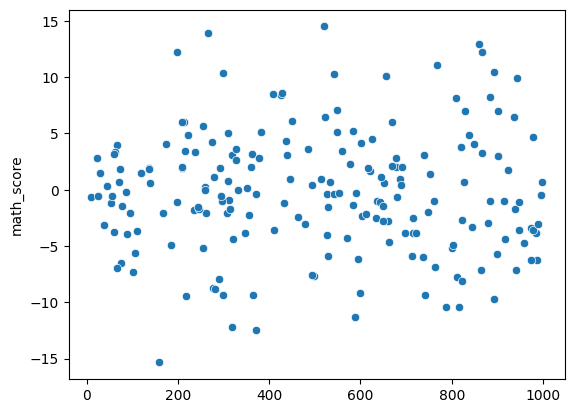

In [60]:
Resdual = y_test - y_pred
sns.scatterplot(Resdual)

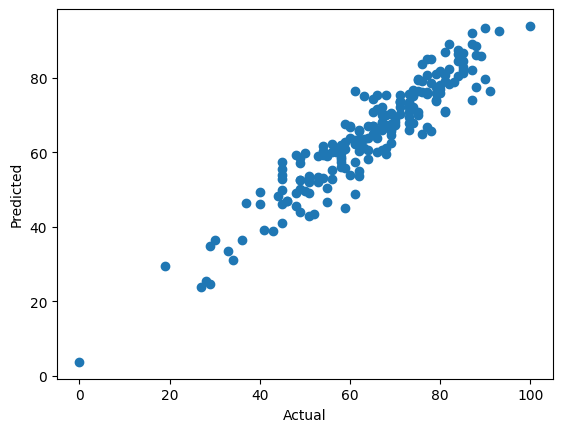

In [61]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

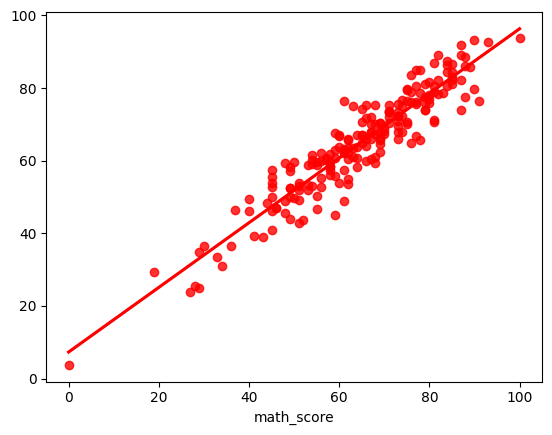

In [62]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')


#### Difference between Actual and Predicted Values



In [64]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.507812,14.492188
737,53,58.953125,-5.953125
740,80,76.960938,3.039062
660,74,76.757812,-2.757812
411,84,87.539062,-3.539062
...,...,...,...
408,52,43.546875,8.453125
332,62,62.031250,-0.031250
208,74,67.976562,6.023438
613,65,67.132812,-2.132812
